# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates.

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation.

# External source of information

[Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [319]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])
    
    
    # New Activation Functions as per task f
    
    def identity(self):
        out_v = self.v
        return Var(out_v, lambda: [(self, 1.0)])

    def tanh(self):
        out_v = (exp(self.v) - exp(-self.v)) / (exp(self.v) + exp(-self.v))
        return Var(out_v, lambda: [(self, 1.0 - out_v**2)])

    def sigmoid(self):
        out_v = 1.0 / (1.0 + exp(-self.v))
        return Var(out_v, lambda: [(self, out_v * (1.0 - out_v))])

A few examples illustrate how we can use this:

In [320]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [321]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables.

4. Write down the sequence of calls to backprop.

In [322]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

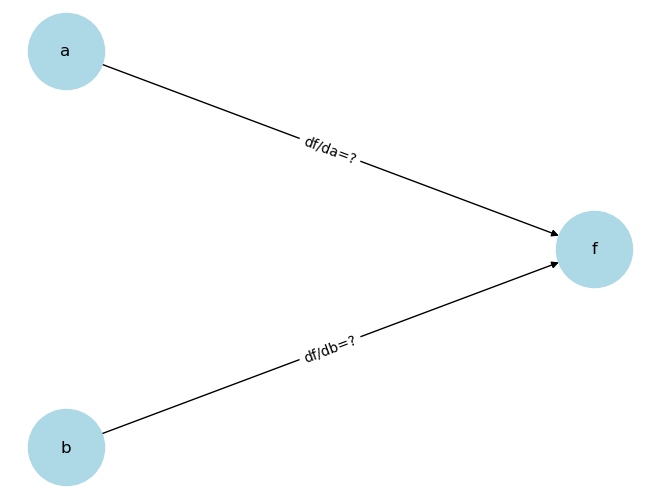

In [323]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=?')
G.add_edge('b', 'f', label='df/db=?')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

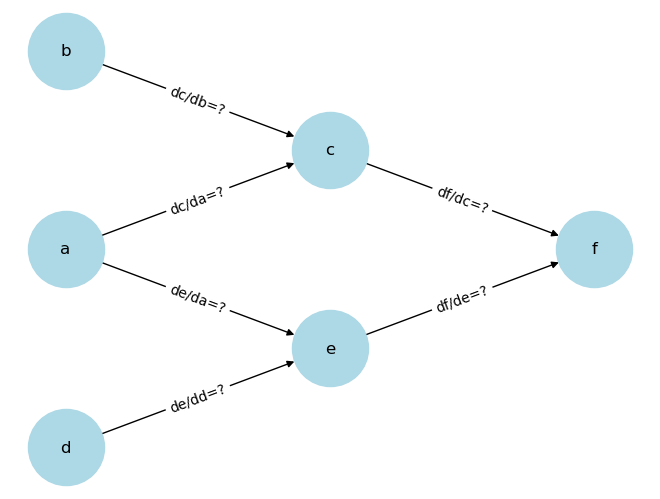

In [324]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=?')
G.add_edge('b', 'c', label='dc/db=?')
G.add_edge('a', 'e', label='de/da=?')
G.add_edge('d', 'e', label='de/dd=?')
G.add_edge('c', 'f', label='df/dc=?')
G.add_edge('e', 'f', label='df/de=?')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [325]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [326]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above.


In [327]:

def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f   # <-- keep this

def finite_difference(da=1e-10):
    a = 4.0

    fa_da = f_function(a + da)[2].v
    fa = f_function(a)[2].v

    return (fa_da - fa) / da

print(finite_difference())

5.000018177270249


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [328]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [329]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T

    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)

    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)

    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma

    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [330]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

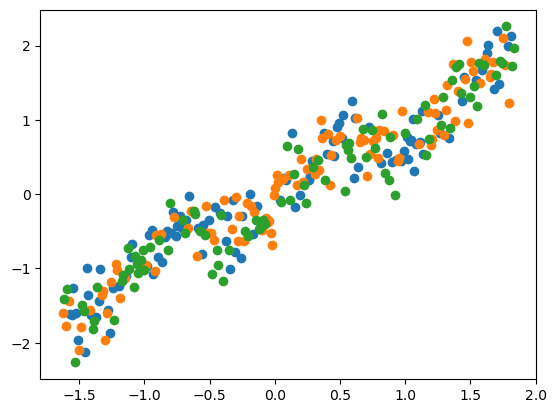

In [331]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [332]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y

x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it.
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [333]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [334]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [335]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn

    def __repr__(self):
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] # <- Inserted code starting with bias
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * weights[i][j]  # <- Inserted code affine transformation
            node = self.act_fn(node)
            out.append(node)

        return out
    
    def print_parameters(self):
        """Prints the weights and biases for this specific layer."""
        print(f"--- Layer {self.act_fn.__name__} (In: {len(self.weights)}, Out: {len(self.bias)}) ---")
        
        # Print Weights
        print(f"  Weights ({len(self.weights)}x{len(self.weights[0])}):")
        for i, input_weights in enumerate(self.weights):
            # Print the weights connecting the i-th input to all outputs
            print(f"    Input {i}: {[w for w in input_weights]}")

        # Print Biases
        print(f"  Biases ({len(self.bias)}):")
        print(f"    {[b for b in self.bias]}")



def print_network_parameters(network):
    """Iterates through all layers in the network and prints their parameters."""
    print("           NETWORK PARAMETERS REPORT          ")
    
    for i, layer in enumerate(network):
        print(f"\n[Layer {i+1}]: {layer}")
        layer.print_parameters()
        


## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu).

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [336]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=0.0048, grad=0.0000)], [Var(v=0.0097, grad=0.0000)], [Var(v=0.0009, grad=0.0000)], [Var(v=0.0335, grad=0.0000)], [Var(v=0.0071, grad=0.0000)], [Var(v=0.0066, grad=0.0000)], [Var(v=0.0043, grad=0.0000)], [Var(v=0.0080, grad=0.0000)], [Var(v=0.0345, grad=0.0000)], [Var(v=0.0026, grad=0.0000)], [Var(v=0.0074, grad=0.0000)], [Var(v=0.0213, grad=0.0000)], [Var(v=0.0060, grad=0.0000)], [Var(v=0.0243, grad=0.0000)], [Var(v=0.0032, grad=0.0000)], [Var(v=0.0062, grad=0.0000)], [Var(v=0.0114, grad=0.0000)], [Var(v=0.0054, grad=0.0000)], [Var(v=0.0006, grad=0.0000)], [Var(v=0.0019, grad=0.0000)], [Var(v=0.0159, grad=0.0000)], [Var(v=0.0070, grad=0.0000)], [Var(v=0.0084, grad=0.0000)], [Var(v=0.0084, grad=0.0000)], [Var(v=0.0093, grad=0.0000)], [Var(v=0.0251, grad=0.0000)], [Var(v=0.0108, grad=0.0000)], [Var(v=0.0119, grad=0.0000)], [Var(v=0.0013, grad=0.0000)], [Var(v=0.0075, grad=0.0000)], [Var(v=0.0314, grad=0.0000)], [Var(v=0.0018, grad=0.0000)], [Var(v=0.0274, grad=0.0000)], [Var(v=0.

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var.

In [337]:
# Insert code here and in the DenseLayer class:

def print_network_parameters(network):
    """Iterates through all layers in the network and prints their parameters."""
    print("           NETWORK PARAMETERS REPORT          ")
    
    for i, layer in enumerate(network):
        print(f"\n[Layer {i+1}]: {layer}")
        layer.print_parameters()
        


In [338]:
# Network Definition 
# NN = [
#     DenseLayer(1, 5, lambda x: x.relu()),
#     DenseLayer(5, 1, lambda x: x.identity())
# ]

# Call the new function
print_network_parameters(NN)

           NETWORK PARAMETERS REPORT          

[Layer 1]: Weights: [[Var(v=-0.1808, grad=0.0000), Var(v=0.0541, grad=0.0000), Var(v=0.0680, grad=0.0000), Var(v=-0.1992, grad=0.0000), Var(v=0.0384, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
--- Layer <lambda> (In: 1, Out: 5) ---
  Weights (1x5):
    Input 0: [Var(v=-0.1808, grad=0.0000), Var(v=0.0541, grad=0.0000), Var(v=0.0680, grad=0.0000), Var(v=-0.1992, grad=0.0000), Var(v=0.0384, grad=0.0000)]
  Biases (5):
    [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]

[Layer 2]: Weights: [[Var(v=-0.0576, grad=0.0000)], [Var(v=-0.0798, grad=0.0000)], [Var(v=0.0954, grad=0.0000)], [Var(v=0.1625, grad=0.0000)], [Var(v=0.1170, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000)]
--- Layer <lambda> (In: 5, Out: 1) ---
  Weights (5x1):


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

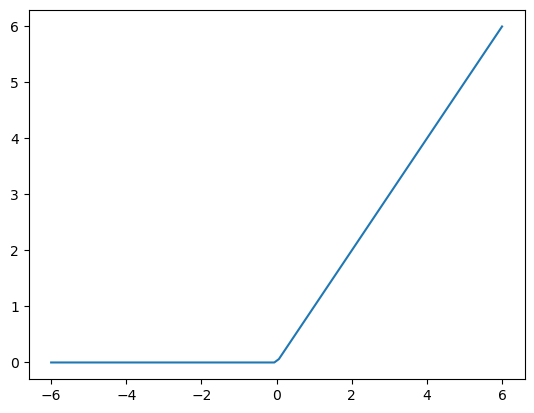

In [339]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ]
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

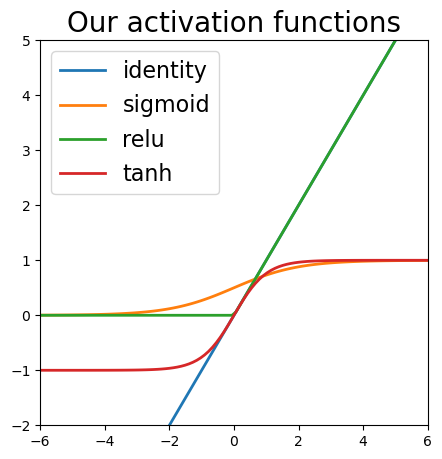

In [340]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf).

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer.

The Glorot initialization has the form:

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).)

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization

Using the Initializer class, implement functions that implement Glorot and He

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

### answer to the question:


The property is tested numerically by examining a deep, untrained neural network. It involves feeding normalized data through the network and verifying signal stability layer by layer. Starting with calculating the standard deviation of the layer activations ($\mathbf{a}^{(L)}$) during the forward pass and the standard deviation of the weight gradients ($\frac{\partial L}{\partial \mathbf{W}^{(L)}}$) after the backward pass. Successful initialization is confirmed if both these variances remain constant (ideally near $1.0$) across all layers, ensuring signals neither vanish nor explode in deep architectures.

In [341]:
# Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  # alpha=1 for tanh, so Variance = 2 / (n_in + n_out)
  std = (2.0 / (n_in + n_out))**0.5
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

# He
def DenseLayer_He_relu(n_in: int, n_out: int):
  # Variance = 2 / n_in
  std = (2.0 / n_in)**0.5
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions.

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands.

In [342]:

# 2. INITIALIZERS (ConstantInitializer needed)
class Initializer:
    def init_weights(self, n_in, n_out): raise NotImplementedError
    def init_bias(self, n_out): raise NotImplementedError

class NormalInitializer(Initializer):
    def __init__(self, std=0.1): self.std = std
    def init_weights(self, n_in, n_out): return [[Var(random.gauss(0, self.std)) for _ in range(n_out)] for _ in range(n_in)]
    def init_bias(self, n_out): return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):
    def __init__(self, constant=1.0):
        self.constant = constant
    
    def init_weights(self, n_in: int, n_out: int) -> Sequence[Sequence[Var]]:
        return [[Var(self.constant) for _ in range(n_out)] for _ in range(n_in)]

    def init_bias(self, n_out: int) -> Sequence[Var]:
        return [Var(self.constant) for _ in range(n_out)]

# 4. UTILITY FUNCTIONS

def list_to_Var(input_list: Sequence[float]) -> Sequence[Var]:
    return [Var(float(x)) for x in input_list]

def Var_to_list(output: Sequence[Var]) -> Sequence[float]:
    return [v.v for v in output]

# test function
def test_forward_pass_unit_test():
    """ Unit test for the DenseLayer forward pass. """
    
    # Setup 2 -> 1 layer with W=1.0, B=1.0, Identity activation
    layer = DenseLayer(
        n_in=2, n_out=1, act_fn=lambda x: x.identity(), 
        initializer = ConstantInitializer(1.0)
    )

    # Input data: [2.0, 3.0]
    input_vars = list_to_Var([2.0, 3.0])

    # Perform the forward pass
    output_vars = layer.forward(input_vars)

    # Expected: 1.0 (Bias) + (2.0 * 1.0) + (3.0 * 1.0) = 6.0
    expected_output = [6.0]
    actual_output = Var_to_list(output_vars)
    
    # Assertions
    assert len(actual_output) == len(expected_output), "Output length mismatch."
    
    all_close = True
    for actual, expected in zip(actual_output, expected_output):
        if abs(actual - expected) > 1e-6: 
            all_close = False
            break

    assert all_close, f"Forward pass failed! Expected: {expected_output}, Got: {actual_output}"
    
print("Unit Test Successful: Forward pass matches expected value (6.0).")


# Execute the unit test
if __name__ == '__main__':
    test_forward_pass_unit_test()

Unit Test Successful: Forward pass matches expected value (6.0).


# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [343]:
def squared_loss(t, y):

  # add check that sizes agree

  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector.

Call the function to convince yourself it works.

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [344]:
def cross_entropy_loss(t: Sequence[Var], h: Sequence[Var]) -> Var:
    """
    Implements Cross-Entropy loss using the numerically stable LogSumExp formulation:
    Loss = - (t * h) + LogSumExp(h)
    
    Args:
        t: Target vector (one-hot encoded, list of Var objects).
        h: Logits vector (raw outputs from the final layer, list of Var objects).
    
    Returns:
        Loss: A single Var object representing the loss value.
    """
    assert len(t) == len(h), "Target (t) and Logits (h) must have the same length."

    # Calculate Term 1: - sum(t_i * h_i)
    negative_dot_product = Var(0.0)
    for t_i, h_i in zip(t, h):
        # We must multiply first, then add to the running total
        negative_dot_product += t_i * h_i
    
    # Negate the final sum
    negative_dot_product = negative_dot_product * Var(-1.0)


    # Calculate Term 2: LogSumExp(h) = log( sum(exp(h_i)) )
    
    # Calculate sum(exp(h_i))
    sum_exp_h = Var(0.0)
    for h_i in h:
        sum_exp_h += h_i.exp()
        
    # Calculate log(sum)
    log_sum_exp_h = sum_exp_h.log()
    
    
    # Final Loss: Term 1 + Term 2
    Loss = negative_dot_product + log_sum_exp_h
    
    return Loss



#### Function call

In [345]:

# Example target (t), One-hot vector for Class 1:
t_target = [Var(1.0), Var(0.0)] 

# Example Logits (h), Raw output from the final layer:
h_logits = [Var(2.0), Var(1.0)] 

loss_result = cross_entropy_loss(t_target, h_logits)

print(f"Target (t): {t_target}")
print(f"Logits (h): {h_logits}")
print(f"Cross-Entropy Loss: {loss_result}")

Target (t): [Var(v=1.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
Logits (h): [Var(v=2.0000, grad=0.0000), Var(v=1.0000, grad=0.0000)]
Cross-Entropy Loss: Var(v=0.3133, grad=0.0000)


# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [346]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [347]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Layer 0 
 Weights: [[Var(v=0.1366, grad=-4.2196), Var(v=-0.0388, grad=-8.4514), Var(v=0.0889, grad=23.7632), Var(v=0.1277, grad=8.5716), Var(v=0.2744, grad=-5.5943)]] Biases: [Var(v=0.0000, grad=-3.6238), Var(v=0.0000, grad=7.6824), Var(v=0.0000, grad=20.4082), Var(v=0.0000, grad=7.3614), Var(v=0.0000, grad=-4.8045)]
Layer 1 
 Weights: [[Var(v=0.0411, grad=-14.0417)], [Var(v=0.0877, grad=3.7364)], [Var(v=-0.2312, grad=-9.1336)], [Var(v=-0.0834, grad=-13.1221)], [Var(v=0.0544, grad=-28.1977)]] Biases: [Var(v=0.0000, grad=-0.6718)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [348]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [349]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Network before update:
Layer 0 
 Weights: [[Var(v=0.1084, grad=8.5534), Var(v=-0.1383, grad=4.5249), Var(v=-0.0644, grad=1.3727), Var(v=0.0338, grad=-4.5860), Var(v=0.0782, grad=-3.9277), Var(v=0.0759, grad=0.5931), Var(v=-0.0457, grad=-0.6845), Var(v=0.1557, grad=1.7750), Var(v=0.0667, grad=6.7663), Var(v=-0.0600, grad=5.7098), Var(v=-0.0046, grad=0.1615), Var(v=0.1092, grad=-7.6207), Var(v=-0.0189, grad=3.1626), Var(v=-0.0067, grad=-2.2481), Var(v=0.2608, grad=4.9561)]] Biases: [Var(v=0.0000, grad=7.3450), Var(v=0.0000, grad=-4.1120), Var(v=0.0000, grad=-1.2475), Var(v=0.0000, grad=-3.9381), Var(v=0.0000, grad=-3.3728), Var(v=0.0000, grad=0.5093), Var(v=0.0000, grad=0.6221), Var(v=0.0000, grad=1.5242), Var(v=0.0000, grad=5.8104), Var(v=0.0000, grad=-5.1888), Var(v=0.0000, grad=-0.1467), Var(v=0.0000, grad=-6.5440), Var(v=0.0000, grad=-2.8740), Var(v=0.0000, grad=2.0430), Var(v=0.0000, grad=4.2559)]
Layer 1 
 Weights: [[Var(v=0.0592, grad=0.0000), Var(v=0.0264, grad=0.0000), Var(v=-0.

[None, None, None]

In [350]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D:
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients
## of the activation functions.

In [351]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3

In [352]:
train_loss = []
val_loss = []

for e in range(EPOCHS):

    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()

    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))

    # Training loss
    train_loss.append(Loss.v)

    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)

    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100),
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))



   0 ( 0.00%) Train loss: 105.699 	 Validation loss: 102.654
  10 ( 5.00%) Train loss: 19.734 	 Validation loss: 14.179
  20 (10.00%) Train loss: 14.306 	 Validation loss: 10.628
  30 (15.00%) Train loss: 13.821 	 Validation loss: 10.314
  40 (20.00%) Train loss: 13.327 	 Validation loss: 10.035
  50 (25.00%) Train loss: 12.833 	 Validation loss: 9.745
  60 (30.00%) Train loss: 12.473 	 Validation loss: 9.515
  70 (35.00%) Train loss: 12.257 	 Validation loss: 9.406
  80 (40.00%) Train loss: 12.120 	 Validation loss: 9.350
  90 (45.00%) Train loss: 12.014 	 Validation loss: 9.271
 100 (50.00%) Train loss: 11.957 	 Validation loss: 9.213
 110 (55.00%) Train loss: 11.926 	 Validation loss: 9.170
 120 (60.00%) Train loss: 11.910 	 Validation loss: 9.139
 130 (65.00%) Train loss: 11.902 	 Validation loss: 9.115
 140 (70.00%) Train loss: 11.897 	 Validation loss: 9.095
 150 (75.00%) Train loss: 11.895 	 Validation loss: 9.080
 160 (80.00%) Train loss: 11.894 	 Validation loss: 9.068
 170 (8

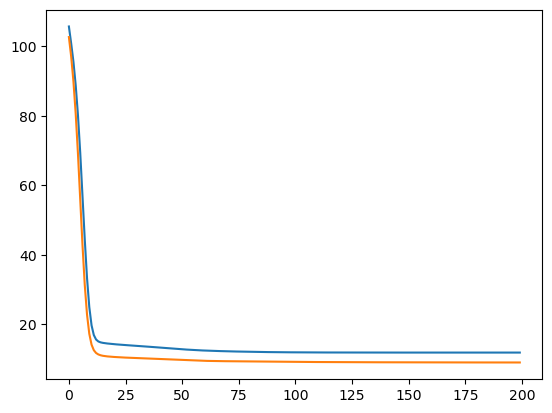

In [353]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [354]:
output_test = forward(x_test, NN)

Test loss:  9.838


<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\sksan\AppData\Local\Temp\ipykernel_16636\1194488628.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


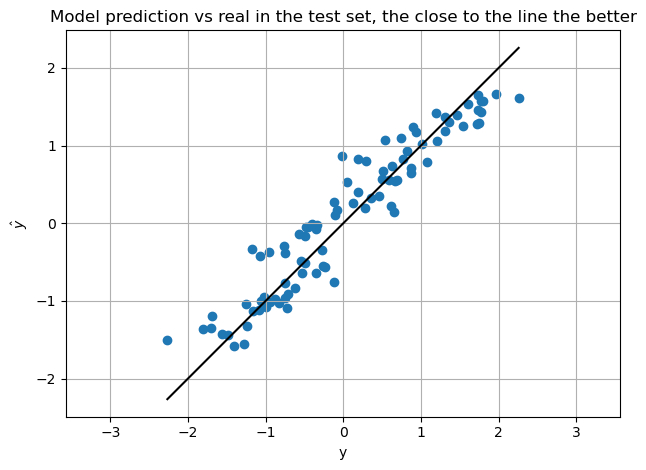

In [355]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

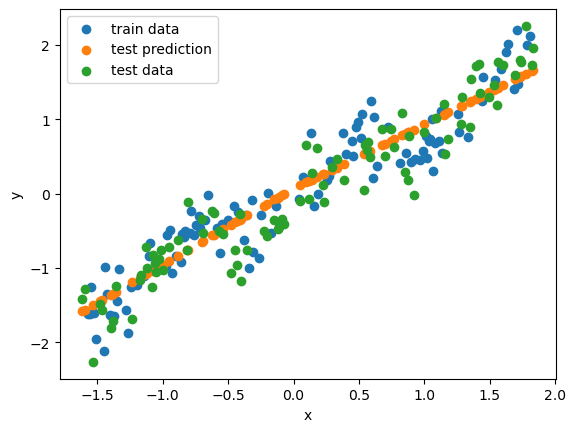

In [356]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss.

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._




In [357]:
# Helper functions for parameter management
def parameters(network) -> list[Var]:
    """Collects all trainable parameters from all layers."""
    params = []
    for layer in network:
        params += layer.parameters()
    return params

def update_parameters(params: list[Var], learning_rate: float):
    """Performs the Gradient Descent step."""
    for p in params:
        p.v -= learning_rate * p.grad

def zero_gradients(params: list[Var]):
    """Resets all gradients to zero."""
    for p in params:
        p.grad = 0.0

# Training Function to run the scenarios
def train_and_evaluate(NN, epochs, learn_r, label):
    print(f"\n--- Scenario: {label} ---")
    train_loss = []
    val_loss = []
    
    # Collect parameters once
    all_params = parameters(NN) 

    for e in range(epochs):
        # Forward pass and loss
        Loss = squared_loss(y_train, forward(x_train, NN))
        
        # Backward pass
        Loss.backward()

        # Update and Zero Gradients
        update_parameters(all_params, learn_r)
        zero_gradients(all_params)

        # Record losses
        train_loss.append(Loss.v)
        Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
        val_loss.append(Loss_validation.v)

        if e % 50 == 0 or e == epochs - 1:
            print(f"Epoch {e:4d}: Train loss: {train_loss[-1]:.4f} | Val loss: {val_loss[-1]:.4f}")
    
    return NN, train_loss, val_loss

def plot_results(scenario_name, NN):
    # Calculate test loss
    output_test = forward(x_test, NN)
    Loss_test = squared_loss(y_test, output_test)
    print(f"\nTest loss for {scenario_name}: {Loss_test.v:.4f}")

    # Plot predictions
    x_test_np = Var_to_nparray(x_test)
    x_train_np = Var_to_nparray(x_train)
    y_train_np = Var_to_nparray(y_train)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x_train_np, y_train_np, label="Train Data", alpha=0.5)
    
    # Sort test data for smooth plot line
    sort_indices = np.argsort(x_test_np[:, 0])
    x_sorted = x_test_np[sort_indices]
    y_pred_sorted = Var_to_nparray(output_test)[sort_indices]
    
    plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=3, label="Model Prediction (Test Set)")
    
    plt.title(f"{scenario_name} (Test Loss: {Loss_test.v:.4f})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Global training parameters
LEARN_R = 5e-3
INITIAL_EPOCHS = 300


--- Scenario: UNDERFITTING: 1-1-1 Linear Model ---
Epoch    0: Train loss: 105.4370 | Val loss: 105.9010
Epoch   50: Train loss: 12.1047 | Val loss: 8.8331
Epoch  100: Train loss: 12.0374 | Val loss: 8.9228
Epoch  150: Train loss: 12.0320 | Val loss: 8.9608
Epoch  200: Train loss: 12.0315 | Val loss: 8.9732
Epoch  250: Train loss: 12.0314 | Val loss: 8.9770
Epoch  299: Train loss: 12.0314 | Val loss: 8.9791

Test loss for Underfitting (1-1-1): 9.3430


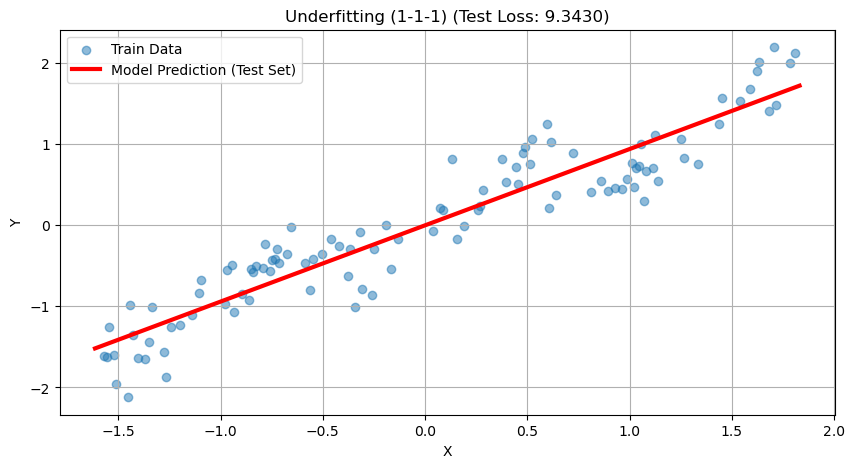

In [358]:
# 1. Underfitting 
NN_underfit = [
    DenseLayer(1, 1, lambda x: x.identity()),
    DenseLayer(1, 1, lambda x: x.identity()) # Essentially a single linear model
]
NN_underfit, _, _ = train_and_evaluate(NN_underfit, INITIAL_EPOCHS, LEARN_R, "UNDERFITTING: 1-1-1 Linear Model")
plot_results("Underfitting (1-1-1)", NN_underfit)

In [ ]:
# 3. Overfitting 
NN_overfit = [
    DenseLayer(1, 32, lambda x: x.tanh()),
    DenseLayer(32, 32, lambda x: x.tanh()),
    DenseLayer(32, 1, lambda x: x.identity()) 
]
# Increase epochs significantly to force overfitting
NN_overfit, _, _ = train_and_evaluate(NN_overfit, INITIAL_EPOCHS * 4, LEARN_R, "OVERFITTING: 1-32-32-1 Tanh Model (Long Training)")
plot_results("Overfitting (1-32-32-1)", NN_overfit)


--- Scenario: OVERFITTING: 1-32-32-1 Tanh Model (Long Training) ---
Epoch    0: Train loss: 104.2264 | Val loss: 54.8429


In [ ]:
# 2. Just Right Fitting 
NN_just_right = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]
NN_just_right, _, _ = train_and_evaluate(NN_just_right, INITIAL_EPOCHS * 2, LEARN_R, "JUST RIGHT: 1-8-1 Relu Model")
plot_results("Just Right (1-8-1)", NN_just_right)

# Next steps - classification

It is straight forward to extend what we have done to classification.

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week.

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it.

In [ ]:
# just add some code